# XGBoost Model Training

In [40]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from skopt import BayesSearchCV
import mlflow.xgboost
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
import seaborn as sns

## Cleaned data import and preparation

In [25]:
# Load the dataset
df = pd.read_csv("../data/cleaned_data.csv", low_memory = False)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('loan_status', axis=1),
                                                        df['loan_status'],
                                                        test_size=0.05,
                                                        stratify=df['loan_status'],
                                                        random_state=77)

 
df = pd.concat([X_test, y_test], axis=1)

Split the target column

In [27]:
X = (df.drop('loan_status', axis=1))  # Features
y = df['loan_status']  # Target variable

Shuffle splits to ensure class distribution in the train and test sets is similar to the original data

In [28]:
# Instantiate StratifiedShuffleSplit with n_splits=1
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=77)

# Split data into train and test
train_index, test_index = next(sss.split(X, y))
X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Further split test data into validation and test
sss_val_test = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=77)
val_index, test_index = next(sss_val_test.split(X_test, y_test))
X_val, X_test = X_test.iloc[val_index], X_test.iloc[test_index]
y_val, y_test = y_test.iloc[val_index], y_test.iloc[test_index]

Set eval set

In [29]:
eval_set = [(X_val, y_val)]

Set Mlflow experiment

In [30]:
experiment_name = "XGBoost_Hyperparameter_Tuning"
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='mlflow-artifacts:/264693245746338625', creation_time=1712153820798, experiment_id='264693245746338625', last_update_time=1712153820798, lifecycle_stage='active', name='XGBoost_Hyperparameter_Tuning', tags={}>

## Model training

In [31]:
clf = xgb.sklearn.XGBClassifier(
    objective="binary:logistic",
    seed=7777,
    eval_metric='auc',
    early_stopping_rounds=20)

Set parameter space which will be iterated through

In [32]:
param_space = {
        'eta': [0.01, 0.03, 0.04, 0.05, 0.1, 0.2, 0.25, 0.3, 0.35, 0.5],
        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'lambda': [0.01, 0.1, 0.2, 0.5, 1, 1.5, 2, 3, 5, 10],
        'alpha': [0, 0.01, 0.05, 0.1, 0.5, 1, 1.5, 2, 3],
        'min_child_weight': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
        'objective':  'binary:logistic',
        'eval_metric': 'auc',
        'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
    }

Initialize Bayes Search

In [33]:
bayes_search = BayesSearchCV(clf, search_spaces=param_space, n_iter=10, scoring='roc_auc', cv=5, verbose=3, n_jobs=-1)

## Mlflow Loggin

In [34]:
with mlflow.start_run():
    bayes_search.fit(X_train, y_train, eval_set=eval_set, verbose=True)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[0]	validation_0-auc:0.90009
[0]	validation_0-auc:0.90010
[0]	validation_0-auc:0.90049
[0]	validation_0-auc:0.89690
[0]	validation_0-auc:0.90003
[1]	validation_0-auc:0.90902
[1]	validation_0-auc:0.89856
[1]	validation_0-auc:0.90390
[1]	validation_0-auc:0.90472
[1]	validation_0-auc:0.90243
[2]	validation_0-auc:0.90525
[2]	validation_0-auc:0.91399
[2]	validation_0-auc:0.91814
[2]	validation_0-auc:0.90395
[2]	validation_0-auc:0.90957
[3]	validation_0-auc:0.90530
[3]	validation_0-auc:0.91863
[3]	validation_0-auc:0.91429
[3]	validation_0-auc:0.91012
[3]	validation_0-auc:0.90396
[4]	validation_0-auc:0.91459
[4]	validation_0-auc:0.90531
[4]	validation_0-auc:0.91022
[4]	validation_0-auc:0.91844
[4]	validation_0-auc:0.91186
[5]	validation_0-auc:0.91541
[5]	validation_0-auc:0.91402
[5]	validation_0-auc:0.91339
[5]	validation_0-auc:0.91945
[5]	validation_0-auc:0.91513
[6]	validation_0-auc:0.91361
[6]	validation_0-auc:0.91539
[6]	validatio

In [35]:
# Log parameters
for param, value in bayes_search.best_params_.items():
    mlflow.log_param(param, value)

# Log metrics
mlflow.log_metric("best_roc_auc", bayes_search.best_score_)

In [36]:
# Evaluate model on test set
y_pred_proba = bayes_search.predict_proba(X_test)[:, 1]
test_roc_auc = roc_auc_score(y_test, y_pred_proba)
mlflow.log_metric("test_roc_auc", test_roc_auc)

In [37]:
array_decimal = np.array([float(np.format_float_positional(x)) for x in y_pred_proba])

# Convert to percentage
probabilities = array_decimal * 100
mlflow.log_artifact(probabilities,"proba_output")

TypeError: expected str, bytes or os.PathLike object, not ndarray

In [ ]:
feature_importance = bayes_search.best_estimator_.feature_importances_
for i, importance in enumerate(feature_importance):
    mlflow.log_metric(f"feature_{i}_importance", importance)

In [ ]:
# Log dataset
mlflow.log_artifact('../data/cleaned_data.csv', artifact_path='datasets')

In [ ]:
# Log model
mlflow.xgboost.log_model(bayes_search.best_estimator_, "xgboost_model")

## ROC_AUC Curve plotting

In [41]:
colors = ['#0476df', '#50b1ff', '#0458a5', '#88cbff', '#00457a', '#032a4d', '#9e9e9e', '#828282', '#0078d6']
sns.set_palette(sns.color_palette(colors))

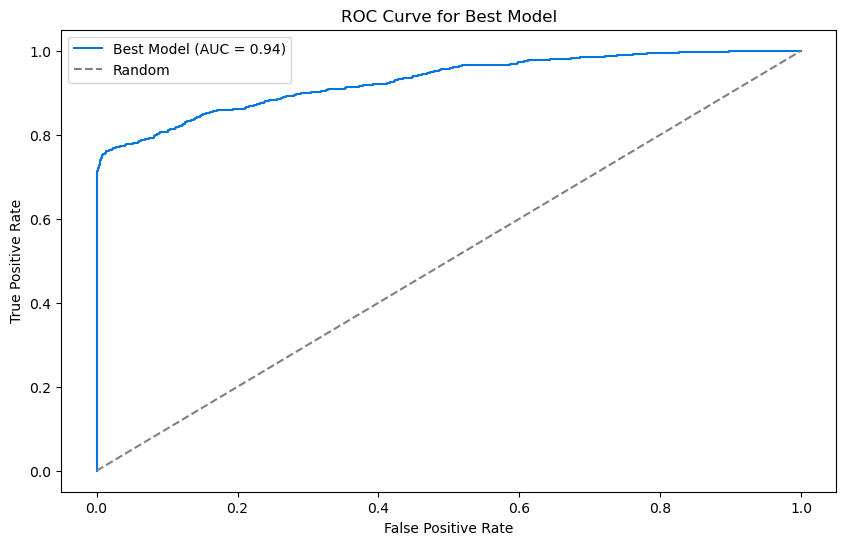

In [42]:
# Prepare ROC AUC Curve
all_roc_auc_scores = bayes_search.cv_results_['mean_test_score']

# Find the index of the top-performing model
best_index = np.argmax(all_roc_auc_scores)
best_params = bayes_search.cv_results_['params'][best_index]
best_roc_auc = all_roc_auc_scores[best_index]

# Plot ROC curve for the best model
plt.figure(figsize=(10, 6))
model = xgb.sklearn.XGBClassifier(**best_params)
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f"Best Model (AUC = {best_roc_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Best Model')
plt.legend()


# Log plot as artifact in MLflow
mlflow.log_artifact(plot_path, "plots")

## Feature importance plotting

In [43]:
feature_importance = bayes_search.best_estimator_.feature_importances_

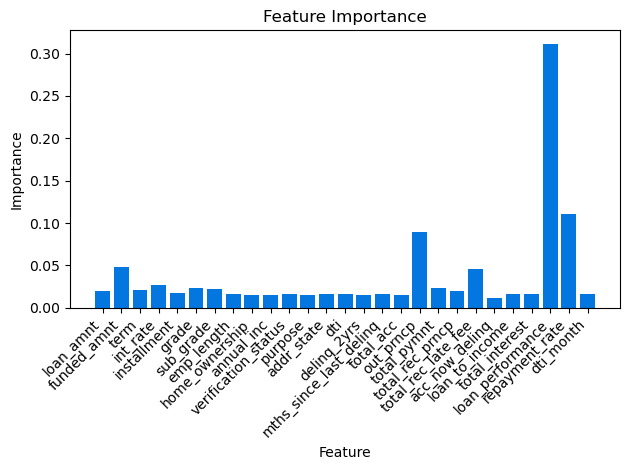

In [46]:
# Plot feature importance
columns = X.columns

# Plot feature importance
plt.bar(range(len(feature_importance)), feature_importance)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(range(len(feature_importance)), columns, rotation=45, ha='right')
plt.tight_layout()

# Display plot
plt.show()

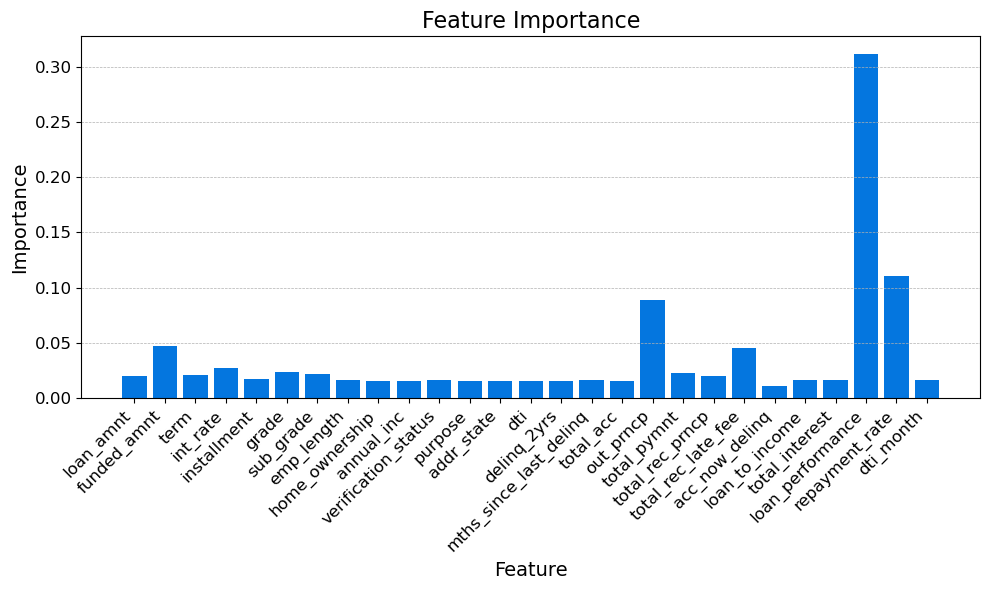